In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import networkx as nx
import matplotlib.patches as mpatches


In [2]:
# df_review = pd.read_csv("yelp_academic_dataset_review.csv")
# df_review = pd.DataFrame(df_review)

In [3]:
# df_review.head(2)

In [4]:
df_business = pd.read_csv("yelp_academic_dataset_business.csv")
df_business = pd.DataFrame(df_business)

In [5]:
len(df_business)

150346

In [6]:
df_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [7]:
# df_user = pd.read_csv("yelp_academic_dataset_user.csv")
# df_user = pd.DataFrame(df_user)

In [8]:
# Filter the dataset to include only restaurants (as done previously)
df_business = df_business[df_business['city']=='Philadelphia']
df_restaurants = df_business[df_business["categories"].str.contains('Restaurants', na=False)]
len(df_restaurants)
# df_restaurants = df_restaurants[:100]

5852

In [9]:
#discover weird restaurants
df_business['categories'] = df_business['categories'].astype(str)
filtered_df = df_business[df_business['categories'].apply(lambda x: 'Restaurants' in x and 'Vinyl Records' in x)]
pd.set_option('display.max_colwidth', None)
filtered_columns = filtered_df[['business_id', 'name', 'categories']]
filtered_columns


,business_id,name,categories
149143,e-ZyZc24wgkKafM3pguR2w,Milkcrate Cafe,"Books, Mags, Music & Video, Restaurants, Vinyl Records, Food, Shopping, Breakfast & Brunch, Coffee & Tea"


In [10]:
unique_categories = set()

# Iterate through the categories and add them to the set
for category_string in df_restaurants['categories']:
    categories = category_string.split(', ')
    unique_categories.update(categories)

sorted_unique_categories = sorted(unique_categories)

print(len(sorted_unique_categories))
print(sorted_unique_categories)


382
['Acai Bowls', 'Active Life', 'Adult', 'Adult Education', 'Adult Entertainment', 'Afghan', 'African', 'Airport Lounges', 'Airport Shuttles', 'American (New)', 'American (Traditional)', 'Apartments', 'Appliances', 'Arabic', 'Arcades', 'Argentine', 'Armenian', 'Art Classes', 'Art Galleries', 'Art Museums', 'Arts & Crafts', 'Arts & Entertainment', 'Asian Fusion', 'Australian', 'Austrian', 'Automotive', 'Axe Throwing', 'Bagels', 'Bakeries', 'Bangladeshi', 'Banks & Credit Unions', 'Barbeque', 'Barbers', 'Bars', 'Bartenders', 'Basque', 'Beaches', 'Beauty & Spas', 'Beer', 'Beer Bar', 'Beer Gardens', 'Beer Hall', 'Belgian', 'Beverage Store', 'Bistros', 'Boat Charters', 'Boat Tours', 'Boating', 'Books', 'Bookstores', 'Bowling', 'Brasseries', 'Brazilian', 'Breakfast & Brunch', 'Breweries', 'Brewpubs', 'British', 'Bubble Tea', 'Buddhist Temples', 'Buffets', 'Burgers', 'Burmese', 'Business Consulting', 'Butcher', 'Cafes', 'Cafeteria', 'Cajun/Creole', 'Cambodian', 'Candle Stores', 'Candy Stores

Categorias a eliminar (exemplos): Acupuncture, Airport Lounges, Commercial Truck Repair, Day Spas, Eatertainment, Event Planning & Services, Fashion, Gas Stations, Hotels & Travel, Museums, Pet Adoption, Sports Wear^, 

In [11]:
relevant_categories = [  #select among these for example
    #'Restaurants',  #do not include this
     'American (Traditional)', 'Italian', 'Mexican', 
    'Chinese', 'Indian', 'Japanese', 'Cafes', 'Bakeries', 
    'Mediterranean', 'Fast Food', 'Buffets', 'Food Trucks', 
    'Bars', 'Pubs', 'Steakhouses', 
    'Sushi Bars', 'Breakfast & Brunch', 'Sandwiches', 
    'Pizza', 'Seafood', 'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 
    'Coffee & Tea', 'Desserts',  'Barbeque', 
    'Food Stands', 'Homemade', 
    'Street Food', 'Bistro', 
    'Sustainable Restaurants'
]

In [12]:
set_categorias_relevantes = set(relevant_categories)

df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in set_categorias_relevantes]
)

# print(df_restaurants[['categories', 'relevant_categories']])


C:\Users\asus\AppData\Local\Temp\ipykernel_4456\1806526835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


Temos de fazer o grafo pelas categorias relevantes. Se usarmos só as categorias todas, fica um círculo preto impossível de ler

In [13]:
# G = nx.Graph()

# for idx, row in df_restaurants.iterrows():
#     restaurant_id = row['business_id']
#     categories = row['relevant_categories']  

#     G.add_node(restaurant_id, relevant_categories=', '.join(categories)) 

# # Criar arestas entre restaurantes que compartilham categorias
# for idx1, row1 in df_restaurants.iterrows():
#     for idx2, row2 in df_restaurants.iterrows():
#         if idx1 < idx2:  # Evitar pares duplicados e auto-laços
#             categories1 = set(row1['relevant_categories'])
#             categories2 = set(row2['relevant_categories'])
#             # Se eles compartilham pelo menos uma categoria, criar uma aresta
#             if categories1 & categories2:  
#                 G.add_edge(row1['business_id'], row2['business_id'])

# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(G, k=0.9)  # Aumentar a força de repulsão

# nx.draw(G, pos, with_labels=False, node_size=500, edge_color="gray", alpha=0.7, node_color="lightblue")

# labels = {node: G.nodes[node]['relevant_categories'] for node in G.nodes}

# offsets = {node: (0.1, 0.1) for node in G.nodes}  #

# nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color="black", verticalalignment='bottom')

# plt.show()


In [14]:
# from collections import Counter

# G = nx.Graph()

# for idx, row in df_restaurants.iterrows():
#     restaurant_id = row['name'] 
#     categories = row['relevant_categories']  
    
#     G.add_node(restaurant_id, relevant_categories=categories)

#     for category in categories:
#         G.add_edge(restaurant_id, category)  

# # Detect communities within the graph
# communities = nx.algorithms.community.greedy_modularity_communities(G)

# # Display the communities and their sizes
# for i, community in enumerate(communities):
#     print(f"Community {i + 1}: {len(community)} restaurants")  
    
#     restaurant_ids = [restaurant for restaurant in community if restaurant in df_restaurants['name'].values]
#     print(f"Restaurants: {restaurant_ids}\n") 
#     common_categories = []
#     for restaurant in restaurant_ids:
#         categories = G.nodes[restaurant]['relevant_categories']  
#         common_categories.extend(categories) 
    
#     # Count occurrences of each category
#     category_counts = Counter(common_categories)  
#     print(f"Most common categories: {category_counts.most_common(3)}\n")  

In [15]:
# plt.figure(figsize=(16, 16))  

# color_map = [0] * G.number_of_nodes()  # Default color for nodes
# for idx, node in enumerate(G.nodes()):
#     for i, community in enumerate(communities):
#         if node in community:
#             color_map[idx] = i  # Assign color based on community index
#             break

# pos = nx.spring_layout(G, k=0.2)  # Adjust k for more spacing between nodes

# nx.draw(G, pos, node_color=color_map, with_labels=True, font_size=10, node_size=700, alpha=0.7, cmap=plt.cm.jet)

# plt.title('Community Structure of Restaurants')
# plt.show()



In [16]:
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

# Create a new graph for categories
G_categories = nx.Graph()

# Loop through each restaurant and add edges between categories
for idx, row in df_restaurants.iterrows():
    categories = row['relevant_categories']
    
    # Add edges between every pair of categories that co-occur
    for i, cat1 in enumerate(categories):
        for cat2 in categories[i + 1:]:
            if G_categories.has_edge(cat1, cat2):
                G_categories[cat1][cat2]['weight'] += 1  # Increment weight for co-occurrence
            else:
                G_categories.add_edge(cat1, cat2, weight=1)  # Create new edge with weight 1

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G_categories)
betweenness_centrality = nx.betweenness_centrality(G_categories)

# Detect communities within the category graph
category_communities = nx.algorithms.community.greedy_modularity_communities(G_categories)

# Print out the most influential categories
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

print("Top 5 categories by degree centrality:")
for category, centrality in sorted_degree[:5]:
    print(f"{category}: {centrality:.4f}")

print("\nTop 5 categories by betweenness centrality:")
for category, centrality in sorted_betweenness[:5]:
    print(f"{category}: {centrality:.4f}")


Top 5 categories by degree centrality:
American (Traditional): 1.0000
Seafood: 1.0000
Breakfast & Brunch: 1.0000
Desserts: 1.0000
Fast Food: 1.0000

Top 5 categories by betweenness centrality:
American (Traditional): 0.0095
Seafood: 0.0095
Breakfast & Brunch: 0.0095
Desserts: 0.0095
Fast Food: 0.0095


In [18]:
# Print the detected communities
print("Detected Communities in the Category Network:")
for i, community in enumerate(category_communities):
    print(f"Community {i + 1}: {sorted(community)}")  


Detected Communities in the Category Network:
Community 1: ['American (Traditional)', 'Barbeque', 'Bars', 'Breakfast & Brunch', 'Buffets', 'Cafes', 'Chinese', 'Cocktail Bars', 'Desserts', 'Fast Food', 'Ice Cream & Frozen Yogurt', 'Indian', 'Japanese', 'Pubs', 'Sandwiches', 'Seafood', 'Steakhouses', 'Sushi Bars']
Community 2: ['Bakeries', 'Coffee & Tea', 'Food Stands', 'Food Trucks', 'Italian', 'Mediterranean', 'Mexican', 'Pizza']


In [20]:
# Calculate Degree Centrality for each node
degree_centrality = nx.degree_centrality(G_categories)

community_1 = list(category_communities[0])  
community_2 = list(category_communities[1]) 

# Extract centrality values for each community
degree_community_1 = [degree_centrality[node] for node in community_1]
degree_community_2 = [degree_centrality[node] for node in community_2]

mean_community_1 = sum(degree_community_1) / len(degree_community_1)
mean_community_2 = sum(degree_community_2) / len(degree_community_2)

sum_community_1 = sum(degree_community_1)
sum_community_2 = sum(degree_community_2)

print(f"Mean Degree Centrality in Community 1: {mean_community_1:.4f}")
print(f"Mean Degree Centrality in Community 2: {mean_community_2:.4f}")
print(f"Sum of Degree Centrality in Community 1: {sum_community_1:.4f}")
print(f"Sum of Degree Centrality in Community 2: {sum_community_2:.4f}")

community_sizes = [len(community) for community in category_communities]

for i, size in enumerate(community_sizes):
    print(f"Community {i + 1} Size: {size} nodes")


Mean Degree Centrality in Community 1: 0.8778
Mean Degree Centrality in Community 2: 0.8350
Sum of Degree Centrality in Community 1: 15.8000
Sum of Degree Centrality in Community 2: 6.6800
Community 1 Size: 18 nodes
Community 2 Size: 8 nodes


In [21]:
# Initialize dictionaries to store total and average edge weights for each community
edge_strengths = {}

# Loop through each community and calculate edge strengths
for i, community in enumerate(category_communities):
    # Create a subgraph for the current community
    subgraph = G_categories.subgraph(community)
    
    # Get all edges in the subgraph
    edges = subgraph.edges(data=True)
    
    # Calculate total weight and number of edges
    total_weight = sum(edge[2]['weight'] for edge in edges)
    num_edges = len(edges)
    
    # Calculate average weight if there are edges
    average_weight = total_weight / num_edges if num_edges > 0 else 0
    
    # Store the results
    edge_strengths[f"Community {i + 1}"] = {
        "Total Weight": total_weight,
        "Average Weight": average_weight,
        "Number of Edges": num_edges
    }

# Print out the results for each community
for community, strengths in edge_strengths.items():
    print(f"{community}:")
    print(f"  Total Weight of Edges: {strengths['Total Weight']:.2f}")
    print(f"  Average Weight of Edges: {strengths['Average Weight']:.2f}")
    print(f"  Number of Edges: {strengths['Number of Edges']}\n")


Community 1:
  Total Weight of Edges: 3156.00
  Average Weight of Edges: 22.23
  Number of Edges: 142

Community 2:
  Total Weight of Edges: 548.00
  Average Weight of Edges: 19.57
  Number of Edges: 28



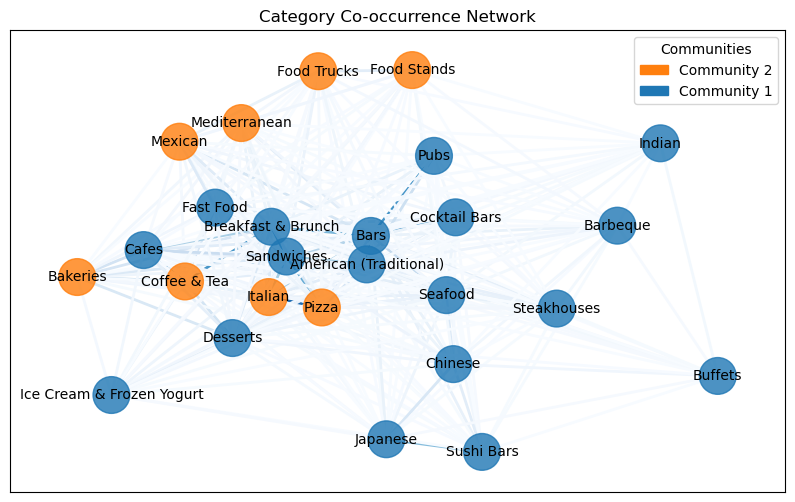

In [52]:

plt.figure(figsize=(10, 6))

# Define colors for the two communities
community_colors = ['#1f77b4', '#ff7f0e']  # Blue and orange, for example

# Get the color map for communities
color_map = [0] * G_categories.number_of_nodes()
community_labels = {}  # Dictionary to store the labels for the legend

for idx, node in enumerate(G_categories.nodes()):
    for i, community in enumerate(category_communities):
        if node in community:
            color_map[idx] = i  # Assign color based on community index
            community_labels[i] = f"Community {i + 1}"  # Label each community
            break

pos = nx.spring_layout(G_categories, k=0.3)  # Adjust k for spacing
edges = G_categories.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

# Draw the network with nodes colored by community
nodes = nx.draw_networkx_nodes(G_categories, pos, node_color=[community_colors[i] for i in color_map],
                                 node_size=700, alpha=0.8)
edges = nx.draw_networkx_edges(G_categories, pos, edge_color=weights,
                                 edge_cmap=plt.cm.Blues, edge_vmin=min(weights), edge_vmax=max(weights), width=2)
labels = nx.draw_networkx_labels(G_categories, pos, font_size=10)

plt.title('Category Co-occurrence Network')

# Create a legend for communities
handles = []
for i, label in community_labels.items():
    patch = mpatches.Patch(color=community_colors[i], label=label)  # Use community-specific colors
    handles.append(patch)

plt.legend(handles=handles, loc='upper right', title="Communities")

plt.show()



In [53]:
# import networkx as nx

# category_communities = nx.algorithms.community.greedy_modularity_communities(G_categories)

# # Extract nodes for the two communities
# community_a = list(category_communities[0])  # First community
# community_b = list(category_communities[1])  # Second community

# intra_edges_a = 0
# intra_edges_b = 0
# inter_edges = 0

# for node_a in community_a:
#     for node_b in community_a:
#         if node_a != node_b and G_categories.has_edge(node_a, node_b):
#             intra_edges_a += 1

# for node_b in community_b:
#     for node_a in community_b:
#         if node_a != node_b and G_categories.has_edge(node_a, node_b):
#             intra_edges_b += 1

# for node_a in community_a:
#     for node_b in community_b:
#         if G_categories.has_edge(node_a, node_b):
#             inter_edges += 1

# # Compute the homophily index
# total_edges = intra_edges_a + intra_edges_b + inter_edges
# if total_edges == 0:  # To avoid division by zero
#     homophily_index = 0
# else:
#     homophily_index = (intra_edges_a + intra_edges_b) / total_edges

# print(f"Homophily Index between the two communities: {homophily_index:.4f}")


Homophily Index between the two communities: 0.7539


In [54]:
import networkx as nx

category_communities = nx.algorithms.community.greedy_modularity_communities(G_categories)

community_a = list(category_communities[0])  # First community
community_b = list(category_communities[1])  # Second community

intra_edges_a = 0
intra_edges_b = 0
inter_edges = 0

for node_a in community_a:
    for node_b in community_a:
        if node_a != node_b and G_categories.has_edge(node_a, node_b):
            intra_edges_a += 1

for node_b in community_b:
    for node_a in community_b:
        if node_a != node_b and G_categories.has_edge(node_a, node_b):
            intra_edges_b += 1

for node_a in community_a:
    for node_b in community_b:
        if G_categories.has_edge(node_a, node_b):
            inter_edges += 1

total_edges = intra_edges_a + intra_edges_b + inter_edges
# Calculate proportions
total_nodes_a = len(community_a)
total_nodes_b = len(community_b)

expected_intra_a = (total_nodes_a * (total_nodes_a - 1)) // 2
expected_intra_b = (total_nodes_b * (total_nodes_b - 1)) // 2
expected_cross = total_nodes_a * total_nodes_b

print(f"Community A (Size: {total_nodes_a}):")
print(f"Intra-community edges: {intra_edges_a}")
print(f"Intra-community edges (expected): {expected_intra_a}")
print()

print(f"Community B (Size: {total_nodes_b}):")
print(f"Intra-community edges: {intra_edges_b}")
print(f"Intra-community edges (expected): {expected_intra_b}")
print()

print("Cross-community edges:")
print(f"Inter-community edges: {inter_edges}")
print(f"Expected cross-community edges: {expected_cross}")
print()

observed_fraction = (intra_edges_a + intra_edges_b) / total_edges if total_edges > 0 else 0
expected_fraction = (expected_intra_a + expected_intra_b) / (expected_intra_a + expected_intra_b + expected_cross)

print(f"Observed fraction of intra-community edges: {observed_fraction:.4f}")
print(f"Expected fraction of intra-community edges: {expected_fraction:.4f}")

# Check evidence for homophily
if observed_fraction < expected_fraction:
    print("Evidence for homophily exists.")
else:
    print("No evidence for homophily.")


Community A (Size: 18):
Intra-community edges: 284
Intra-community edges (expected): 153

Community B (Size: 8):
Intra-community edges: 56
Intra-community edges (expected): 28

Cross-community edges:
Inter-community edges: 111
Expected cross-community edges: 144

Observed fraction of intra-community edges: 0.7539
Expected fraction of intra-community edges: 0.5569
No evidence for homophily.


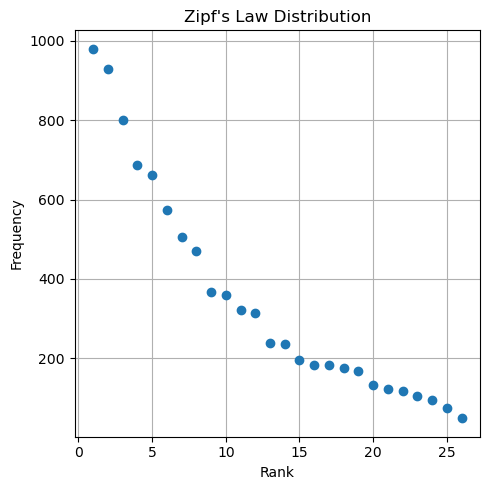

In [65]:
all_categories = [cat for sublist in df_restaurants['relevant_categories'] for cat in sublist]
category_counts = pd.Series(all_categories).value_counts()
plt.figure(figsize=(5, 5))
ranked_categories = category_counts.sort_values(ascending=False)
ranks = np.arange(1, len(ranked_categories) + 1)
# Plot the Zipf's Law
plt.plot(ranks, ranked_categories, marker='o', linestyle='None')
plt.title("Zipf's Law Distribution")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()


In [59]:
pip install powerlaw

  Obtaining dependency information for powerlaw from https://files.pythonhosted.org/packages/e8/26/e0daa306f83d705bc1ed4d6759b7fc945cc787530c230ee1fe299cc28093/powerlaw-1.5-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


Calculating best minimal value for power law fit


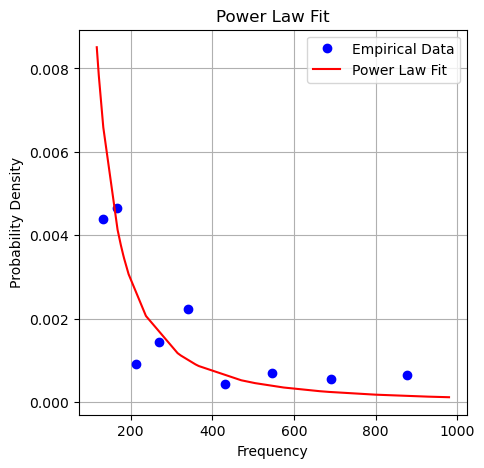

Alpha (power law exponent): 1.9954


In [64]:
import powerlaw
import matplotlib.pyplot as plt

results = powerlaw.Fit(category_counts.values)
fig = plt.figure(figsize=(5, 5))
results.plot_pdf(color='b', marker='o', linestyle='None', label='Empirical Data')

results.power_law.plot_pdf(color='r', linestyle='-', label='Power Law Fit')

plt.title("Power Law Fit")
plt.xlabel("Frequency")
plt.ylabel("Probability Density")
plt.xscale('linear')  # Set x-axis to linear scale
plt.yscale('linear')  # Set y-axis to linear scale
plt.legend()
plt.grid(True)
plt.show()

print(f"Alpha (power law exponent): {results.power_law.alpha:.4f}")



Now with the method that we learned in the lecture:

Detected Communities:
Community 1: {'Desserts', 'Sushi Bars', 'Coffee & Tea', 'Breakfast & Brunch', 'Barbeque', 'Bakeries', 'Mexican', 'Italian', 'Bars', 'Japanese', 'Cocktail Bars', 'Pizza', 'Chinese', 'Pubs', 'Food Stands', 'Mediterranean', 'Sandwiches', 'Seafood', 'Ice Cream & Frozen Yogurt', 'Steakhouses', 'Food Trucks', 'Fast Food', 'Indian', 'American (Traditional)', 'Cafes'}
Community 2: {'Buffets'}


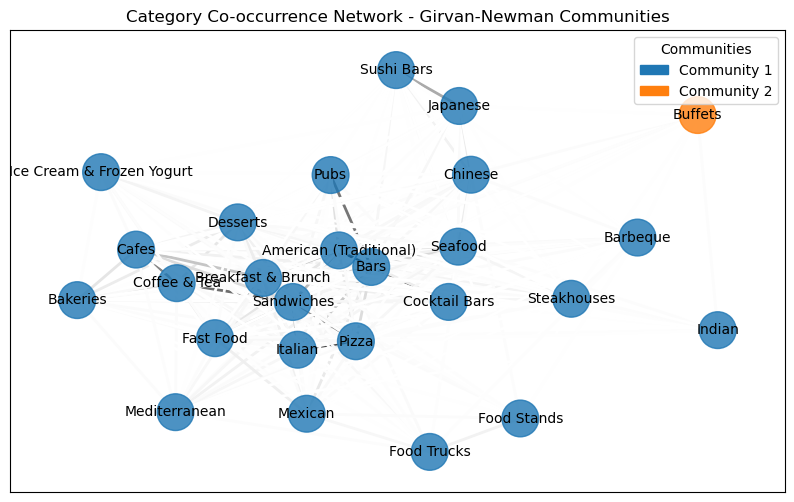

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Generate communities using the Girvan-Newman algorithm
communities_generator = nx.community.girvan_newman(G_categories)
first_community = next(communities_generator)  # Get the first set of communities
first_community = list(first_community)  # Convert to list

# Print out the detected communities
print("Detected Communities:")
for i, community in enumerate(first_community):
    print(f"Community {i + 1}: {community}")

# Visualize the category network with Girvan-Newman communities
plt.figure(figsize=(10, 6))

# Define colors for the two communities
community_colors = ['#1f77b4', '#ff7f0e']  # Blue and orange

# Get the color map for communities
color_map = [0] * G_categories.number_of_nodes()
community_labels = {}  # Dictionary to store the labels for the legend

for idx, node in enumerate(G_categories.nodes()):
    for i, community in enumerate(first_community):
        if node in community:
            color_map[idx] = i  # Assign color based on community index
            community_labels[i] = f"Community {i + 1}"  # Label each community
            break

pos = nx.spring_layout(G_categories, k=0.3)  # Adjust k for spacing

nodes = nx.draw_networkx_nodes(G_categories, pos, 
                                 node_color=[community_colors[i] for i in color_map],
                                 node_size=700, alpha=0.8)

# edges = nx.draw_networkx_edges(G_categories, pos, 
#                                  edge_color='lightgray', width=2)

edges = nx.draw_networkx_edges(G_categories, pos, 
                                 edge_color=weights,
                                 edge_cmap=plt.cm.Greys, 
                                 edge_vmin=min(weights), 
                                 edge_vmax=max(weights), 
                                 width=2)


labels = nx.draw_networkx_labels(G_categories, pos, font_size=10)

plt.title('Category Co-occurrence Network - Girvan-Newman Communities')

# Create a legend for communities
handles = []
for i, label in community_labels.items():
    patch = mpatches.Patch(color=community_colors[i], label=label)  # Use community-specific colors
    handles.append(patch)

plt.legend(handles=handles, loc='upper right', title="Communities")

plt.show()

